# Aula 1: Maze

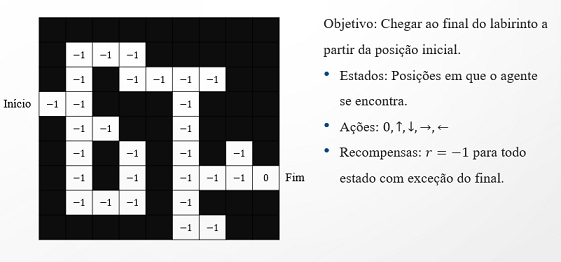

## Google Drive

Mount de drive e configuração de working directory para permitir salvar resultados.

Atenção: Modificar o comando "%cd \<filepath\>" para conter o filepath do arquivo A1_Maze.ipynb no seu drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/Shareddrives/Aulas\ Maua\ RL/Code/Aulas/Aula\ 1/
%ls

/content/drive/Shareddrives/Aulas Maua RL/Code/Aulas/Aula 1
A1_Maze.ipynb         Maze_OptimalAgent.gif  random_agent.gif
Aula1_MazeExample.py  Maze_RandomAgent.gif


## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import imageio

## Maze

Em primeiro lugar, é preciso codificar o ambiente. Vamos representar o labirinto por uma matriz binária onde:

- 0: Indica que a célula contém uma parede.
- 1: CIndica que a célula faz parte do caminho do labirinto.

Além disso, vamos especificar posições de início e fim para o agente.

In [4]:
# Initialize Maze Matrix and Start/End Positions
maze_matrix = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],\
                        [0, 1, 1, 1, 0, 0, 0, 0, 0],\
                        [0, 1, 0, 1, 1, 1, 1, 0, 0],\
                        [1, 1, 0, 0, 0, 1, 0, 0, 0],\
                        [0, 1, 1, 0, 0, 1, 0, 0, 0],\
                        [0, 1, 0, 1, 0, 1, 0, 1, 0],\
                        [0, 1, 0, 1, 0, 1, 1, 1, 1],\
                        [0, 1, 1, 1, 0, 1, 0, 0, 0],\
                        [0, 0, 0, 0, 0, 1, 1, 0, 0]])
start_pos = np.array([3,0])
end_pos = np.array([6,8])
print(maze_matrix)

[[0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0]
 [0 1 0 1 1 1 1 0 0]
 [1 1 0 0 0 1 0 0 0]
 [0 1 1 0 0 1 0 0 0]
 [0 1 0 1 0 1 0 1 0]
 [0 1 0 1 0 1 1 1 1]
 [0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 1 1 0 0]]


## State Space and Action Space

Vamos inicializar os espaços de estados e ações do problema



In [5]:

# Action Space
#--------------
# 0: Stand Still
# 1: Move North
# 2: Move South
# 3: Move East
# 4: Move West
ACTION_SPACE = np.array([0,1,2,3,4])
print('Action Space: ' + str(ACTION_SPACE))

# State Space
#--------------
# Each '1' cell in maze_matrix corresponds to a different state
STATE_SPACE = []
for i in range(np.shape(maze_matrix)[0]):
  for j in range(np.shape(maze_matrix)[1]):
    if (maze_matrix[i][j] == 1):
      STATE_SPACE.append(np.array([i,j]))
print('State Space: ' + str(STATE_SPACE))

# MAX_TIMESTEP (Maximum number of actions taken before episode ends)
MAX_TIMESTEP = int(1e6)

# Discount Factor Gamma
GAMMA = 1


Action Space: [0 1 2 3 4]
State Space: [array([1, 1]), array([1, 2]), array([1, 3]), array([2, 1]), array([2, 3]), array([2, 4]), array([2, 5]), array([2, 6]), array([3, 0]), array([3, 1]), array([3, 5]), array([4, 1]), array([4, 2]), array([4, 5]), array([5, 1]), array([5, 3]), array([5, 5]), array([5, 7]), array([6, 1]), array([6, 3]), array([6, 5]), array([6, 6]), array([6, 7]), array([6, 8]), array([7, 1]), array([7, 2]), array([7, 3]), array([7, 5]), array([8, 5]), array([8, 6])]


## Funções Auxiliares

### fig2img(fig):
Função que recebe uma figura da biblioteca matplotlib e retorna a imagem PIL RGBA correspondente

In [6]:
#------------------------------------------------------------------------------
# fig2img(fig, np_array=False)
#
# INPUT:
# fig: matplotlib figure object
#
# OUTPUT:
# img: Image of the given figure
#------------------------------------------------------------------------------
def fig2img(fig, np_array=False):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, orientation='landscape')
    buf.seek(0)
    img = Image.open(buf)
    if (np_array):
        img = np.array(img)
    return img

### get_state_index(state):
Função que recebe um estado (np array) e retorna seu índice no STATE_SPACE

In [7]:
def get_state_index(state):
    for i in range(0,len(STATE_SPACE)):
        s = STATE_SPACE[i]
        if np.all(s == state):
            return i
    
    print ('state not found!')
    return 0

### save_episode_animation(env, episode, name):
Função que recebe uma lista de transições correspondente a um episódio e salva uma animação em formato gif.

In [8]:
def save_episode_animation(env, episode, name, fps=30):
    img_list = []
    cont = 0
    for t in episode:
        # Get state
        s = t.state
        # Obtain state image from environment
        img = env.show(state=s,t=cont,open_figure=False,np_array=True)
        img_list.append(img)
        # Increment counter
        cont += 1

    # Convert image list to gif
    gif_name = name +'.gif'
    imageio.mimsave(gif_name, img_list, fps=fps)

## Environment Class

Em aplicações de Aprendizado por Reforço é comum a criação de uma classe que representa o ambiente, a qual possui uma função de visualização do estado (env.show()) e uma função que implementa a dinâmica de transição de estados (env.step()).

In [9]:
# Maze
# PROPERTIES:
# Maze_matrix: 2D Numpy array representing maze (1: Path, 0: Wall)
# start_pos: Maze start position (1D numpy array with shape=(2,))
# end_pos: Maze end position (1D numpy array with shape=(2,))
#
#
# METHODS:
# __init__: Class default constructor
# show(self, state): Show the maze on given state
# step(self, state, action): Perform Environment Dynamics step given state and action
class Maze:
    def __init__(self, matrix, start_pos, end_pos):
        self.matrix = matrix
        self.start_pos = start_pos
        self.end_pos = end_pos
        
    #------------------------------------------------------------------------------
    # show(self, state, t=None, open_figure=False)
    #
    # INPUT:
    # state: Current agent position (1D numpy array with shape=(2,))
    # open_figure: Whether to open the matplotlib figure or just return as image
    # t: Timestep (int)
    # open_figure: Indicates whether to open matplotlib figure or just save img (Bool)
    # np_array: Indicates whether to return image as numpy array or PIL Image
    #
    # OUTPUT:
    # img: Image of the Environment
    #------------------------------------------------------------------------------
    def show(self, state, t=None, open_figure=False, np_array=False):
        fig = plt.figure()
        ax = fig.gca()
        # Plot Maze
        ax.imshow(self.matrix, interpolation='nearest', cmap=cm.Greys_r)
        # Plot Agent
        ax.scatter(state[1], state[0], s=128, color='b')
        if (t):
            title_str = 'Maze: t = ' + str(t)
        else:
            title_str = 'Maze'
        ax.set_title(title_str)
        
        img = fig2img(fig,np_array)
        if (open_figure==False):
            plt.close(fig)
        
        return img
        
        
    
    #------------------------------------------------------------------------------
    # step(self, state, action)
    #
    # INPUT:
    # state: Current agent position (1D numpy array with shape=(2,))
    # action: Action taken (0: Stand Still, 1: North, 2: South, 3: East, 4: West)
    #
    # OUTPUT:
    # next_state: Next agent position (1D numpy array with shape=(2,))
    # reward: Immediate Reward obtained (float)
    #------------------------------------------------------------------------------
    def step(self, state, action):

        # a = 0: Stand Still
        if (action == 0):
            next_state = state
            
        # a = 1: North
        elif (action == 1):
            next_pos = np.array([state[0] - 1, state[1]])
            if (next_pos[0] < 0 or next_pos[0] >= np.shape(self.matrix)[0]):
                next_state = state
            elif (self.matrix[next_pos[0]][next_pos[1]] == 0):
                next_state = state
            else:
                next_state = next_pos
                
        # a = 2: South
        elif (action == 2):
            next_pos = np.array([state[0] + 1, state[1]])
            if (next_pos[0] < 0 or next_pos[0] >= np.shape(self.matrix)[0]):
                next_state = state
            elif (self.matrix[next_pos[0]][next_pos[1]] == 0):
                next_state = state
            else:
                next_state = next_pos
        
        # a = 3: East
        elif (action == 3):
            next_pos = np.array([state[0], state[1] + 1])
            if (next_pos[1] < 0 or next_pos[1] >= np.shape(self.matrix)[1]):
                next_state = state
            elif (self.matrix[next_pos[0]][next_pos[1]] == 0):
                next_state = state
            else:
                next_state = next_pos
        
        # a = 4: West
        elif (action == 4):
            next_pos = np.array([state[0], state[1] - 1])
            if (next_pos[1] < 0 or next_pos[1] >= np.shape(self.matrix)[1]):
                next_state = state
            elif (self.matrix[next_pos[0]][next_pos[1]] == 0):
                next_state = state
            else:
                next_state = next_pos
        
        # Reward
        if (state[0] == self.end_pos[0] and state[1] == self.end_pos[1]):
            reward = 0
            next_state = state
            done = True
        else:
            reward = -1
            done = False
        
        
        return reward, next_state, done

### Create Environment
Utilizando as variáveis maze_matrix, start_pos e end_pos criadas anteriormente podemos criar um objeto da classe Maze:

In [10]:
# Create Environment object
env = Maze(maze_matrix, start_pos, end_pos)

### Test: env.show()
Vamos testar a função env.show() mostrando o estado inicial do ambiente:

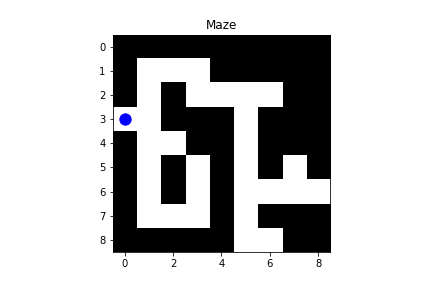

In [11]:
env.show(start_pos)

### Test: env.step()
Vamos testar agora a função de transição de estados e verificar se a dinâmica do sistema e a função de recompensa desejada são corretamente implementadas.

In [12]:
# Test Case 1:
#---------------
# state: start_pos, action: 0  (Stand Still)
# next_state: [3,0], # reward: -1, # done: False
state = start_pos
action = 0
r, next_state, done = env.step(state, action)
print('Test 1:')
print('-----------')
print('state: ' + str(state))
print('action: ' + str(action))
print('next_state: ' + str(next_state))
print('reward: ' + str(r))
print('done: ' + str(done))
print('')

# Test Case 2:
#---------------
# state: start_pos, action: 1  (North)
# next_state: [3,0], # reward: -1, # done: False
state = start_pos
action = 1
r, next_state, done = env.step(state, action)
print('Test 2:')
print('-----------')
print('state: ' + str(state))
print('action: ' + str(action))
print('next_state: ' + str(next_state))
print('reward: ' + str(r))
print('done: ' + str(done))
print('')

# Test Case 3:
#---------------
# state: start_pos, action: 2  (South)
# next_state: [3,0], # reward: -1, # done: False
state = start_pos
action = 2
r, next_state, done = env.step(state, action)
print('Test 3:')
print('-----------')
print('state: ' + str(state))
print('action: ' + str(action))
print('next_state: ' + str(next_state))
print('reward: ' + str(r))
print('done: ' + str(done))
print('')

# Test Case 4:
#---------------
# state: start_pos, action: 3  (East)
# next_state: [3,1], # reward: -1, # done: False
state = start_pos
action = 3
r, next_state, done = env.step(state, action)
print('Test 4:')
print('-----------')
print('state: ' + str(state))
print('action: ' + str(action))
print('next_state: ' + str(next_state))
print('reward: ' + str(r))
print('done: ' + str(done))
print('')

# Test Case 5:
#---------------
# state: start_pos, action: 4  (West)
# next_state: [3,0], # reward: -1, # done: False
state = start_pos
action = 4
r, next_state, done = env.step(state, action)
print('Test 5:')
print('-----------')
print('state: ' + str(state))
print('action: ' + str(action))
print('next_state: ' + str(next_state))
print('reward: ' + str(r))
print('done: ' + str(done))
print('')

Test 1:
-----------
state: [3 0]
action: 0
next_state: [3 0]
reward: -1
done: False

Test 2:
-----------
state: [3 0]
action: 1
next_state: [3 0]
reward: -1
done: False

Test 3:
-----------
state: [3 0]
action: 2
next_state: [3 0]
reward: -1
done: False

Test 4:
-----------
state: [3 0]
action: 3
next_state: [3 1]
reward: -1
done: False

Test 5:
-----------
state: [3 0]
action: 4
next_state: [3 0]
reward: -1
done: False



## Agent Class

Vamos implementar um agente que executa uma política aleatória, ou seja, cada ação do agente é amostrada de uma distribuição uniforme independente do estado no qual ele se encontra.

In [13]:
#--------------------------------------------
# Agent
# PROPERTIES:
# policy:
#
#
# METHODS:
# __init__: Class default constructor
# get_action (self, state): Applies policy to obtain action
class Agent:
    # policy: Numpy array with shape=(n,m) with probabilities of m actions for each state
    def __init__(self, policy):
        self.policy = policy
    
    #------------------------------------------------------------------------------
    # get_action(self, state)
    #
    # INPUT:
    # state: Current agent position (1D numpy array with shape=(2,))
    #
    # OUTPUT:
    # action: Action taken (0: Stand Still, 1: North, 2: South, 3: East, 4: West)
    #------------------------------------------------------------------------------
    def get_action(self, state):
        i = get_state_index(state)
        action_probs = self.policy[i,:]
        action = np.random.choice(ACTION_SPACE, p=action_probs)
        
        return action

### Random Agent

Vamos criar um agente que executa uma política aleatória

In [14]:
# Random Policy
n = len(STATE_SPACE)
m = len(ACTION_SPACE)
random_policy = (1/m)*np.ones((n,m))
print('Random Policy:')
print(random_policy)
# Random Agent
random_agent = Agent(random_policy)

Random Policy:
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]


## Transition Class

Em diversos algoritmos de Aprendizado por Reforço, é interessante armazenar transições da forma (s,a,r,s',done), de modo que seja possível construir um estrutura de dados que represente a experiência ou "memória" do agente.

Vamos implementar a classe Transition, que simplesmente armazena uma tupla (s,a,r,s',done):

In [15]:
#--------------------------------------------
# Transition
# PROPERTIES:
# state: Current agent position (1D numpy array with shape=(2,) or list)
# action: Action taken (0: Stand Still, 1: North, 2: South, 3: East, 4: West)
# reward: Immediate Reward obtained (float)
# next_state: Next agent position (1D numpy array with shape=(2,) or list)
# terminal: Whether the next state is terminal (Bool)
#
#
# METHODS:
# __init__: Class default constructor
class Transition:
    def __init__(self, state, action, reward, next_state, done):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.done = done

## Generate Episode
A partir do ambiente e do agente podemos agora gerar um episódio, definido por uma tentativa do agente de solucionar o labirinto, que termina quando a posição de destino é alcançada ou quando MAX_TIMESTEP ações são tomadas.

In [16]:
def generate_episode(env, agent):

    episode = []

    # Initialize state
    s = env.start_pos
    # Main Loop
    for i in range(MAX_TIMESTEP):
        # Monitor timestep
        if(i % 100 == 0):
            print('t = ' + str(i))
        # Sample action from agent
        a = agent.get_action(s)
        # Environment Dynamics
        r, s_next, done = env.step(s, a)
        # Save transition
        transition = Transition(s, a, r, s_next, done)
        episode.append(transition)
        # Check if episode ended
        if (done):
            break
        # State transition
        s = s_next

    return episode


### Test: generate_episode()
Vamos testar a função de geração de um episódio a partir do agente de política aleatória implementado anteriormente:

In [17]:
# generate episode
episode = generate_episode(env, random_agent)

t = 0
t = 100
t = 200
t = 300
t = 400
t = 500
t = 600
t = 700
t = 800
t = 900
t = 1000
t = 1100
t = 1200
t = 1300
t = 1400


In [18]:
# save episode animation
save_episode_animation(env, episode, 'random_agent', fps=50)

## Value Function

Vamos criar uma função que estima $V_{\pi}(s)$. Por definição, temos que o valor de um estado é dado pelo retorno esperado obtido a partir daquele estado ($V_{\pi}(s) = E_{\pi}[G_t|S_t=s]$). Assim, um método de estimar $V_{\pi}(s)$ consiste em calcular a média dos retornos obtidos a partir de cada estado ao longo de múltiplos episódios (Monte-Carlo Prediction).

### calculate_returns(episode)
Função que recebe um episódio e calcula a lista de retornos $G_t$.

In [19]:
def calculate_returns(episode):
    T = len(episode)

    returns = []
    G = 0
    for i in range(T-1,-1,-1):
        G = episode[i].reward + GAMMA*G
        returns.append(G)
    
    returns.reverse()
    return returns

In [20]:
returns = calculate_returns(episode)
print('List of returns G_t from t = 0 to t = ' + str(len(episode)-1))
print(returns)

List of returns G_t from t = 0 to t = 1430
[-1430, -1429, -1428, -1427, -1426, -1425, -1424, -1423, -1422, -1421, -1420, -1419, -1418, -1417, -1416, -1415, -1414, -1413, -1412, -1411, -1410, -1409, -1408, -1407, -1406, -1405, -1404, -1403, -1402, -1401, -1400, -1399, -1398, -1397, -1396, -1395, -1394, -1393, -1392, -1391, -1390, -1389, -1388, -1387, -1386, -1385, -1384, -1383, -1382, -1381, -1380, -1379, -1378, -1377, -1376, -1375, -1374, -1373, -1372, -1371, -1370, -1369, -1368, -1367, -1366, -1365, -1364, -1363, -1362, -1361, -1360, -1359, -1358, -1357, -1356, -1355, -1354, -1353, -1352, -1351, -1350, -1349, -1348, -1347, -1346, -1345, -1344, -1343, -1342, -1341, -1340, -1339, -1338, -1337, -1336, -1335, -1334, -1333, -1332, -1331, -1330, -1329, -1328, -1327, -1326, -1325, -1324, -1323, -1322, -1321, -1320, -1319, -1318, -1317, -1316, -1315, -1314, -1313, -1312, -1311, -1310, -1309, -1308, -1307, -1306, -1305, -1304, -1303, -1302, -1301, -1300, -1299, -1298, -1297, -1296, -1295, -129

### MC_Prediction(env, agent, N)
Função que aplica Monte-Carlo Prediction sobre N episódios para estimar a Função Valor $V_{\pi}(s)$.

In [21]:
def MC_Prediction(env, agent, N):
    n = len(STATE_SPACE)
    returns_per_state = [[] for i in range(n)]

    for episode_index in range(0,N):
        print('Episode: ' + str(episode_index+1))
        # Simulate Episode
        print('Simulating Episode...')
        episode = generate_episode(env, agent)
        # Calculate Returns
        returns = calculate_returns(episode)
        T = len(episode)
        for i in range(0,T):
            transition = episode[i]
            state = transition.state
            state_index = get_state_index(state)
            returns_per_state[state_index].append(returns[i])

    # Average Returns
    V_pi_estimate = [np.mean(e) for e in returns_per_state]

    return V_pi_estimate

In [22]:
V_pi_estimate = MC_Prediction(env, random_agent, 100)
print(V_pi_estimate)

Episode: 1
Simulating Episode...
t = 0
t = 100
Episode: 2
Simulating Episode...
t = 0
t = 100
t = 200
t = 300
t = 400
t = 500
t = 600
t = 700
t = 800
t = 900
t = 1000
t = 1100
t = 1200
t = 1300
t = 1400
t = 1500
Episode: 3
Simulating Episode...
t = 0
t = 100
t = 200
t = 300
t = 400
t = 500
t = 600
t = 700
Episode: 4
Simulating Episode...
t = 0
t = 100
t = 200
Episode: 5
Simulating Episode...
t = 0
t = 100
t = 200
t = 300
t = 400
t = 500
t = 600
t = 700
t = 800
t = 900
t = 1000
t = 1100
t = 1200
t = 1300
t = 1400
t = 1500
t = 1600
t = 1700
t = 1800
t = 1900
t = 2000
Episode: 6
Simulating Episode...
t = 0
t = 100
t = 200
t = 300
t = 400
t = 500
t = 600
t = 700
t = 800
t = 900
t = 1000
t = 1100
t = 1200
t = 1300
t = 1400
t = 1500
t = 1600
t = 1700
t = 1800
t = 1900
t = 2000
t = 2100
t = 2200
t = 2300
t = 2400
t = 2500
t = 2600
t = 2700
Episode: 7
Simulating Episode...
t = 0
t = 100
t = 200
t = 300
t = 400
t = 500
t = 600
t = 700
t = 800
t = 900
t = 1000
t = 1100
t = 1200
t = 1300
t = 1400

### plot_value_function(env, V)
Função que recebem e plota função valor $V(s)$ sobre labirinto.

In [23]:
def plot_value_function(env,V):
  n = len(STATE_SPACE)
  V_grid = np.zeros(np.shape(env.matrix))
  for i in range(0,n):
    s = STATE_SPACE[i]
    V_grid[s[0]][s[1]] = V[i]
  
  # Plot Gridworld
  fig = plt.figure()
  ax = fig.gca()
  C = ax.imshow(V_grid, interpolation='nearest', cmap='RdYlGn') # Plot Value Function Colormap
  aux = env.matrix
  aux = np.ma.masked_where(aux > 0.5, aux)
  ax.imshow(aux, interpolation='nearest', cmap=cm.Greys_r) # Plot Walls on top

  fig.colorbar(C, ax=ax) # Add Colorbar
  ax.set_title('Value Function') # Set Title

  img = fig2img(fig)
  plt.close(fig)

  print('Value Function V(s):')
  print(V_grid.astype(int))
        
  return img

Value Function V(s):
[[    0     0     0     0     0     0     0     0     0]
 [    0  -989  -910  -850     0     0     0     0     0]
 [    0 -1055     0  -812  -770  -766  -701     0     0]
 [-1069 -1059     0     0     0  -712     0     0     0]
 [    0 -1101 -1185     0     0  -549     0     0     0]
 [    0 -1177     0 -1247     0  -460     0  -201     0]
 [    0 -1232     0 -1228     0  -378  -269  -174     0]
 [    0 -1256 -1277 -1217     0  -363     0     0     0]
 [    0     0     0     0     0  -360  -439     0     0]]


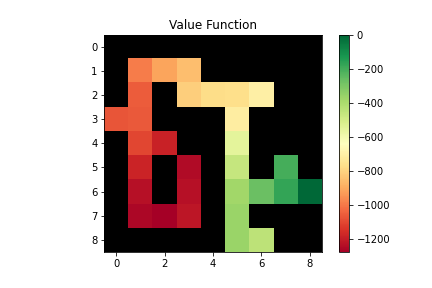

In [24]:
plot_value_function(env, V_pi_estimate)